In [6]:
### demonstrates how to use some functions in fit_template.R
### load template fitting code and templates
rm(list=ls())
source("fit_template.R")
load("template_sdss.RData")
tem_sdss <- tem
load("template_des.RData")
tem_des <- tem
tem <- NULL


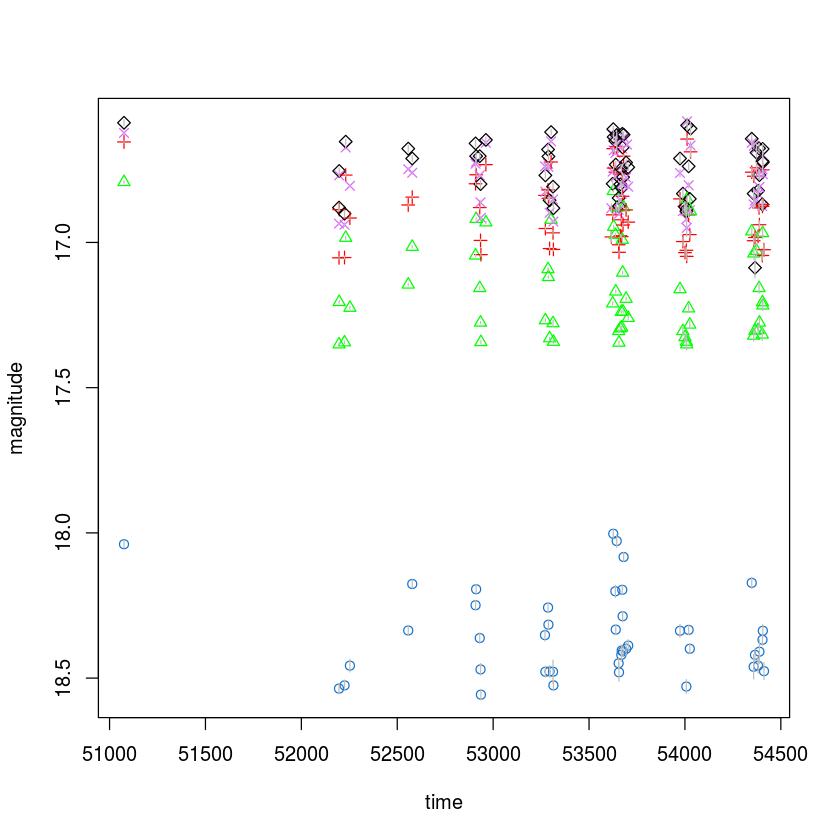

In [7]:
## read in data and plot
fname <- "LC_4099.dat"
lc <- read.table(fname,stringsAsFactors=FALSE)
names(lc) <- c("time","band","mag","error")

## colors for plotting
bandpch <- 1:6
names(bandpch) <- c("u","g","r","i","z","Y")
bandcol <- c("dodgerblue3","green","red",
             "mediumorchid1","black","peachpuff4")
names(bandcol) <- c("u","g","r","i","z","Y")

## plot raw light curve
plot(lc$time,lc$mag,col=bandcol[lc$band],pch=bandpch[lc$band],
     ylim=rev(range(lc$mag)),
     xlab="time",ylab="magnitude")
segments(lc$time,lc$mag+lc$error,lc$time,lc$mag-lc$error,col='grey')


In [8]:
## true period of source is 0.6417558

## makes nice plots, used later
plotLC <- function(lc,p_est,coeffs,tem){
    lc1 <- lc
    lc1[,1] <- (lc$time %% p_est)/p_est
    lc2 <- lc1
    lc2[,1] <- lc1[,1] + 1
    lc_temp <-rbind(lc1,lc2)
    plot(lc_temp$time,lc_temp$mag,
         col=bandcol[lc_temp$band],pch=bandpch[lc_temp$band],
         ylim=rev(range(lc_temp$mag)),
         xlab="phase",ylab="magnitude",
         xlim=c(0,2),xaxs='i')
    segments(lc_temp$time,
             lc_temp$mag+lc_temp$error,
             lc_temp$time,
             lc_temp$mag-lc_temp$error,col='grey')
    ti <- seq(0,p_est,length.out=100)
    ti <- c(ti,ti+p_est)
    m <- PredictAllBand(ti,1/p_est,coeffs,tem)
    for(ii in 1:ncol(m)){
        points(ti/p_est,m[,ii],type='l',col=bandcol[colnames(m)[ii]])
    }
}


[1] 0.6417558

mu         ebv         amp       phase 
16.17424095  0.05122535  0.58949133  0.24304760

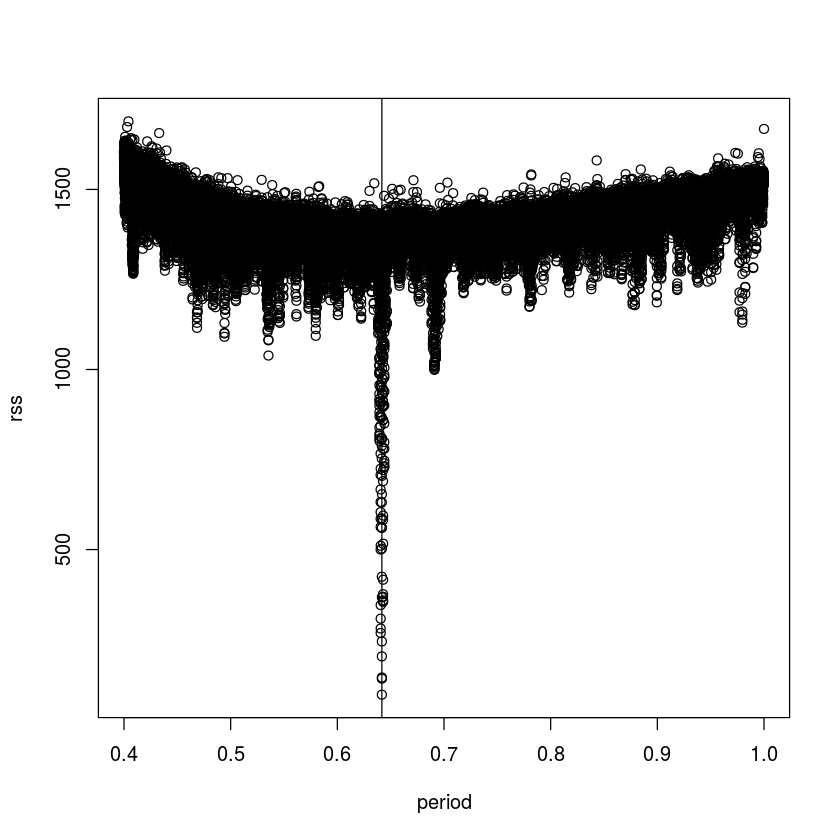

In [10]:
##
## PART 1: test if model is working in the most standard mode
##         (fitting for dust and using photometric errors)
##         


## fit template model and obtain coefficients
omegas <- seq(from=1.0,to=2.5,by=0.1/4000.0)
rss <- FitTemplate(lc,omegas,tem_sdss)
omega_est <- omegas[which.min(rss)]
p_est <- 1/omega_est
p_est
coeffs <- ComputeCoeffs(lc,omega_est,tem_sdss)
names(coeffs) <- c("mu","ebv","amp","phase")
coeffs
## correct values near:
## > coeffs
##          mu         ebv         amp       phase 
## 16.17423839  0.05122597  0.58949080  0.24304752 
## p_est
## [1] 0.6417558

plot(1/omegas,rss,xlab="period",ylab="rss")
abline(v=p_est)



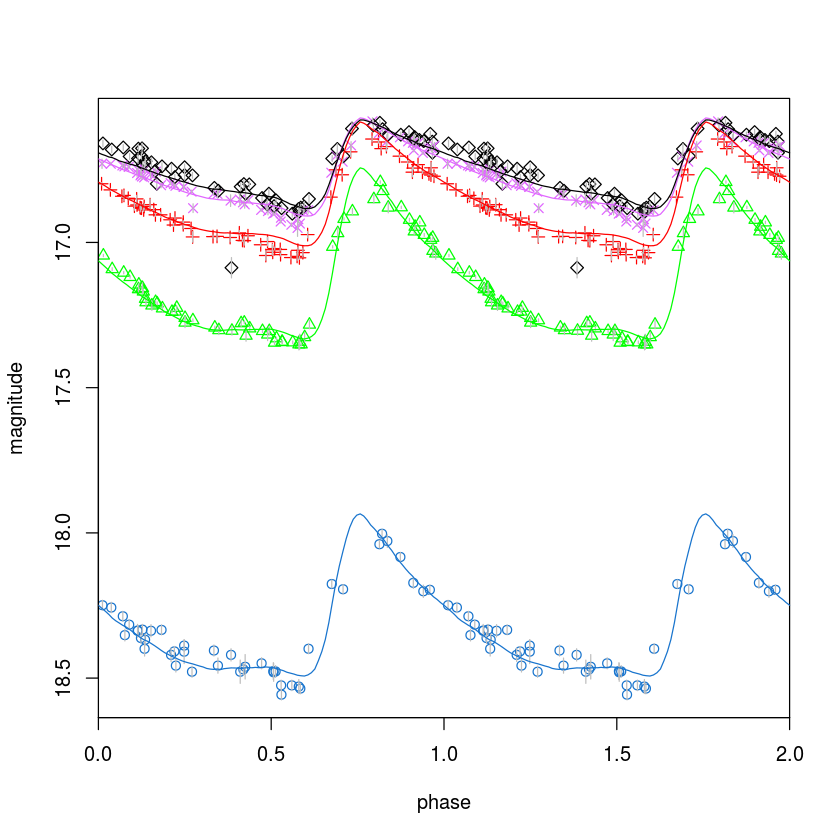

In [11]:
## plot folded light curve with best fit
plotLC(lc,p_est,coeffs,tem_sdss)


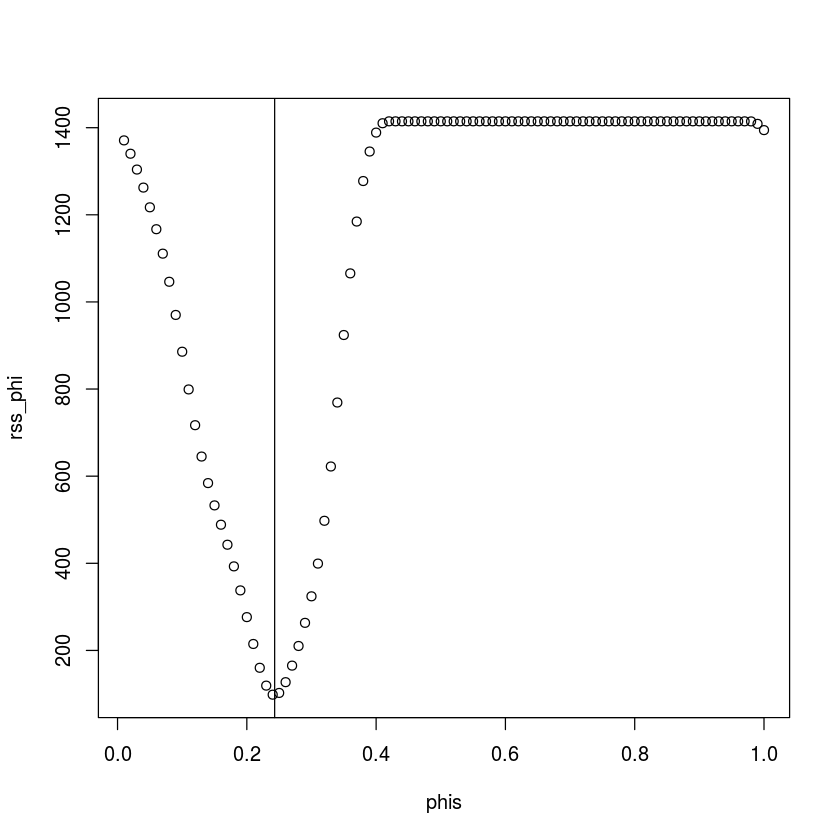

In [12]:
## check that phase determined by NewtonUpdate is close to best phase
## by performing a grid search on phase, comparing min of grid
## search to min found by newton
phis <- (1:100)/100
rss_phi <- ComputeRSSPhase(lc,omega_est,tem_sdss,phis=phis)
plot(phis,rss_phi)
abline(v=coeffs[4])


In [ ]:
##
## PART 2: refit model, subtracting off dust first
##         here we test if model works when use.dust=FALSE
##         we use dust computed from earlier run (coeffs[2]),
##         but in practice would use values from dust maps
ebv <- coeffs[2]
## remove dust
bands <- names(tem_sdss$dust)
for(ii in 1:length(bands)){
    lc$mag[lc$band==bands[ii]] <- lc$mag[lc$band==bands[ii]] - tem_sdss$dust[ii]*ebv
}


rss <- FitTemplate(lc,omegas,tem_sdss,use.dust=FALSE)
omega_est <- omegas[which.min(rss)]
p_est <- 1/omega_est
coeffs <- ComputeCoeffs(lc,omega_est,tem_sdss,use.dust=FALSE)
names(coeffs) <- c("mu","ebv","amp","phase")

## view rss
plot(1/omegas,rss,xlab="period",ylab="rss")
abline(v=p_est)

## plot folded light curve with best fit
plotLC(lc,p_est,coeffs,tem_sdss)



## check that phase determine by NewtonUpdate is close to best phase
## by performing a grid search
phis <- (1:100)/100
rss_phi <- ComputeRSSPhase(lc,omega_est,tem_sdss,phis=phis,use.dust=FALSE)
plot(phis,rss_phi)
abline(v=coeffs[4])



##
## PART 3: make some observations in lc very bad
##         
ix <- sample(1:nrow(lc),floor(nrow(lc)*.6))
lc[ix,3] <- lc[ix,3] + rnorm(length(ix),mean=0,sd=3)
lc[ix,4] <- sqrt(lc[ix,4]^2 + 3^2)

## plot raw light curve
colpch <- 1:5
names(colpch) <- unique(lc$band)
plot(lc$time,lc$mag,col=colpch[lc$band],pch=colpch[lc$band],
     ylim=rev(range(lc$mag)),
     xlab="time",ylab="magnitude")
segments(lc$time,lc$mag+lc$error,lc$time,lc$mag-lc$error)


###### a) use.errors=TRUE
rss <- FitTemplate(lc,omegas,tem_sdss)
omega_est <- omegas[which.min(rss)]
p_est <- 1/omega_est
coeffs <- ComputeCoeffs(lc,omega_est,tem_sdss)
names(coeffs) <- c("mu","ebv","amp","phase")
coeffs
### E[B-V] should be near 0
## coeffs
##           mu          ebv          amp        phase 
## 16.107599078 -0.002595868  0.575895456  0.274028610 

## view rss
plot(1/omegas,rss,xlab="period",ylab="rss")
abline(v=p_est)

## plot folded light curve with best fit
plotLC(lc,p_est,coeffs,tem_sdss)

## check that phase determine by NewtonUpdate is close to best phase
## by performing a grid search
phis <- (1:100)/100
rss_phi <- ComputeRSSPhase(lc,omega_est,tem_sdss,phis=phis)
plot(phis,rss_phi)
abline(v=coeffs[4])


###### b) use.errors=FALSE, should get poor parameter estimates
rss <- FitTemplate(lc,omegas,tem_sdss,use.errors=FALSE)
omega_est <- omegas[which.min(rss)]
p_est <- 1/omega_est
coeffs <- ComputeCoeffs(lc,omega_est,tem_sdss,use.errors=FALSE)
names(coeffs) <- c("mu","ebv","amp","phase")
coeffs
p_est

## view rss
plot(1/omegas,rss,xlab="period",ylab="rss")
abline(v=p_est)

## plot folded light curve with best fit
plotLC(lc,p_est,coeffs,tem_sdss)

## check that phase determine by NewtonUpdate is close to best phase
## by performing a grid search
phis <- (1:100)/100
rss_phi <- ComputeRSSPhase(lc,omega_est,tem_sdss,phis=phis,use.errors=FALSE)
plot(phis,rss_phi)
abline(v=coeffs[4])





##
## PART 4: templates on des data
##         


## read in sdss data
fname <- "LC_402316.dat"
lc <- read.table(fname,stringsAsFactors=FALSE)
names(lc) <- c("time","band","mag","error")


## fit model
rss <- FitTemplate(lc,omegas,tem_sdss)
omega_est <- omegas[which.min(rss)]
p_est <- 1/omega_est
coeffs <- ComputeCoeffs(lc,omega_est,tem_sdss)
names(coeffs) <- c("mu","ebv","amp","phase")
coeffs


plot(1/omegas,rss,xlab="period",ylab="rss")
abline(v=p_est)

## plot folded light curve with best fit
plotLC(lc,p_est,coeffs,tem_sdss)



## read in des data for same light curve
fname <- "LC_402316_des.dat"
lc_des <- read.table(fname,header=TRUE,stringsAsFactors=FALSE)
lc_des <- lc_des[,c(1,4,2,3)]
names(lc_des) <- c("time","band","mag","error")

## refit coefficients using des data and templates
coeffs_des <- ComputeCoeffs(lc_des,omega_est,tem_des)
plotLC(lc_des,p_est,coeffs_des,tem_des)


## estimate period with des templates
rss_des <- FitTemplate(lc_des,omegas,tem_des)
omega_est_des <- omegas[which.min(rss_des)]
p_est_des <- 1/omega_est_des

par(mfcol=c(2,1))
plot(1/omegas,rss,xlab="period",ylab="rss sloan data")
abline(v=p_est)
plot(1/omegas,rss_des,xlab="period",ylab="rss des data")
abline(v=p_est_des)


p_est_des
p_est


